<a href="https://colab.research.google.com/github/Jeongin205/BadWordCheck/blob/main/%EB%82%98%EC%81%9C%EB%A7%90%ED%8C%90%EB%B3%84%EA%B8%B0%EC%B5%9C%EC%A2%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 설치

In [ ]:
!pip install konlpy
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 46.8 MB/s eta 0:00:00
  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-66rma2p9
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-66rma2p9
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit 5bb0b3e8f62c1936a430745297821a9ecd78beb1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.4/371.4 kB 34.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is l

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파이어베이스

In [ ]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

In [ ]:
cred = credentials.Certificate("/content/drive/MyDrive/bad-words-14c4b-firebase-adminsdk-q4bmv-bc45bdd4af.json")
firebase_admin.initialize_app(cred,{
    'databaseURL' : 'https://bad-words-14c4b-default-rtdb.firebaseio.com/'
})

In [ ]:
# #문장들 파베에 넣어주는 코드

# with open("/content/drive/MyDrive/bad_sentence_dataset.txt", 'r') as f:
#   lines = f.readlines()
#   for idx, data in enumerate(lines):
#     words = data.split("|")
#     words[1] = words[1].replace("\n", "")
#     dir = db.reference('문장/' + str(idx))
#     dir.update({'sentence':words[0], 'negative':int(words[1])})

# 학습

In [ ]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import json
from wordcloud import WordCloud
from konlpy.tag import Okt
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import save_model,load_model

In [ ]:
df = pd.DataFrame(columns=['text', 'label'])
def load_sentence():
  list_s = db.reference('문장').get()
  texts = []
  labels = []
  for i, data in enumerate(list_s):
    df.loc[i] = [data.get('sentence'), data.get('negative')]
load_sentence()
train_text = [sentence for sentence in df['text'] if type(sentence) is str]
negative_text = [text for text, label in zip(df['text'], df['label']) if label == 1]
df.head()

,text,label
0,좌배 까는건 ㅇㅂ,1
1,집에 롱 패딩만 세 개다. 10년 더 입어야지 ㅋㅋ,0
2,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
3,세탁이라고 봐도 된다,0
4,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6074 entries, 0 to 6073
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6074 non-null   object
 1   label   6074 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.4+ KB


In [ ]:
print('욕설이 섞이지 않은 문장 갯수: {}'.format(df['label'].value_counts()[0]))
print('욕설이 섞인 문장 갯수: {}'.format(df['label'].value_counts()[1]))

욕설이 섞이지 않은 문장 갯수: 3884
욕설이 섞인 문장 갯수: 2190


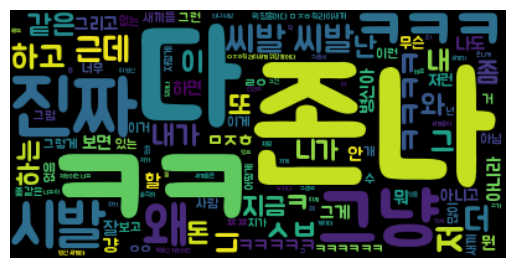

In [ ]:
wordcloud = WordCloud('/content/drive/MyDrive/BMJUA_ttf.ttf').generate(' '.join(negative_text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#전처리 함수 만들기
def preprocessing(sentence, okt, stop_words =[]):
  #함수인자설명
  # sentence: 전처리할 텍스트
  # okt: okt객체를 반복적으로 생성하지 않고 미리 생성 후 인자로 받음
  # stop_words: 불용어 사전은 사용자가 직접 입력

  # 1. 한글 및 공백 제외한 문자 모두 제거
  sentence_text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',sentence)

  #2. okt 객체를 활용하여 형태소 단어로 나눔
  word_sentence = okt.morphs(sentence_text,stem=True)

  #3. 불용어 제거
  word_sentence = [token for token in word_sentence if not token in stop_words]
  return word_sentence

In [ ]:
# 전체 텍스트 전처리
# JSON 파일 불러오기
with open('/content/drive/MyDrive/stopwords-ko.json', 'r', encoding='utf-8') as f:
    stop_words = json.load(f)

In [ ]:
okt = Okt()
clean_train_sentence = []

for sentence in df['text']:
  # 문장이 문자열인 경우만 전처리 진행
  if type(sentence) == str:
    clean_train_sentence.append(preprocessing(sentence,okt, stop_words= stop_words))
  else:
    clean_train_sentence.append([]) #str이 아닌 행은 빈칸으로 놔두기

clean_train_sentence[:4]

[['좌배', '깔다', 'ㅇㅂ'],
 ['집', '롱', '패딩', '만', '세', '개다', '더', '입다', 'ㅋㅋ'],
 ['개',
  '소리',
  '니',
  '빨갱이',
  '옹호',
  '하고',
  '드루',
  '킹',
  'ㅇㅇ',
  '짓',
  '이라고',
  '말',
  '못',
  '하다',
  '삐지다',
  '빨갱'],
 ['세탁', '이라고', '보다', '되다']]

In [ ]:
# 인덱스 벡터 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_sentence)
train_sequences = tokenizer.texts_to_sequences(clean_train_sentence)

word_vocab = tokenizer.word_index # 단어사전형태
print(word_vocab)

{'하다': 1, '은': 2, '도': 3, '는': 4, '아니다': 5, '보다': 6, '되다': 7, '없다': 8, '새끼': 9, '다': 10, '안': 11, '한': 12, '고': 13, 'ㅋㅋ': 14, '못': 15, '만': 16, '그렇다': 17, '이다': 18, '말': 19, '거': 20, 'ㅋㅋㅋ': 21, '사람': 22, '씨발': 23, '임': 24, '존나': 25, '먹다': 26, '게': 27, '니': 28, '개': 29, '가다': 30, '병신': 31, '하고': 32, '진짜': 33, '돈': 34, '내': 35, '면': 36, '맞다': 37, '들다': 38, '뭐': 39, '좋다': 40, '적': 41, '그냥': 42, '생각': 43, '더': 44, '받다': 45, '지': 46, '인': 47, '애': 48, '알다': 49, '인데': 50, '오다': 51, '치다': 52, '라': 53, '나오다': 54, '많다': 55, '용접': 56, '근데': 57, '않다': 58, '좆': 59, '한테': 60, '놈': 61, '함': 62, '시발': 63, '이나': 64, '주다': 65, '글': 66, '서': 67, '기': 68, '잘': 69, '지다': 70, '정도': 71, 'ㅋㅋㅋㅋ': 72, '모르다': 73, '나다': 74, '한국': 75, '냐': 76, '일본': 77, '살다': 78, '랑': 79, '소리': 80, '지랄': 81, '나라': 82, 'ㅁㅈㅎ': 83, '지금': 84, '일베': 85, '여자': 86, 'ㅋ': 87, '이냐': 88, '수': 89, '쓰다': 90, '씹다': 91, '많이': 92, '이지': 93, '안되다': 94, '공부': 95, '난': 96, '자다': 97, '이렇다': 98, '보고': 99, '라고': 100, '따다': 101, '중': 102, '이라고': 103, '

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10725
등장 빈도가 2번 이하인 희귀 단어의 수: 7443
단어 집합에서 희귀 단어의 비율: 69.3986013986014
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 15.003789251705163


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 3283


In [ ]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(clean_train_sentence)
train_sequences = tokenizer.texts_to_sequences(clean_train_sentence)

문장의 최대 길이 : 360
문장의 평균 길이 : 8.493743826144222


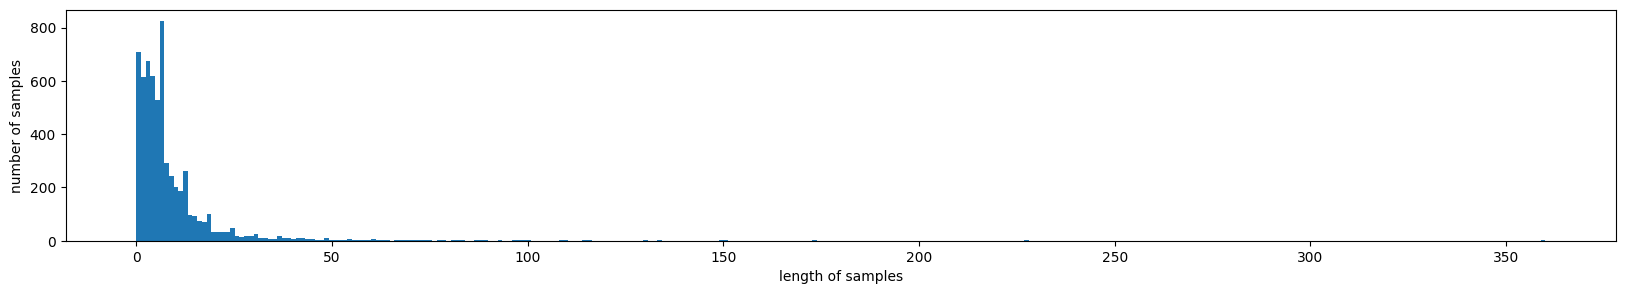

In [ ]:
print('문장의 최대 길이 :',max(len(sentence) for sentence in train_sequences))
print('문장의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.figure(figsize=(20,3))
plt.hist([len(sentence) for sentence in train_sequences], bins=300)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 8
below_threshold_len(max_len, train_sequences)

전체 샘플 중 길이가 8 이하인 샘플의 비율: 70.16792887718142


In [ ]:
MAX_SEQUENCE_LENGTH = max_len  #문장 최대 길이

#학습 데이터
train_inputs = pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH,padding='post')

#학습 데이터 라벨 벡터화
train_labels = np.array(df['label'])

In [ ]:
model_name= 'bad_word_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = train_inputs.shape[1]

kargs={'model_name': model_name, 'vocab_size': vocab_size,'embbeding_size':100, 'num_filters':128, 'dropout_rate':0.5, 'hidden_dimension':256, 'output_dimension':1}

In [ ]:
class CNNClassifier(tf.keras.Model):

  def __init__(self, **kargs):
    super(CNNClassifier, self).__init__(name=kargs['model_name'])
    self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embbeding_size'])
    self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], kernel_size=kernel_size, padding='valid',activation = tf.keras.activations.relu,
                                    kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3)) for kernel_size in [3,4,5]]
    self.pooling = layers.GlobalMaxPooling1D()
    self.dropout = layers.Dropout(kargs['dropout_rate'])
    self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                            activation = tf.keras.activations.relu,
                            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    self.fc2 = layers.Dense(units=kargs['output_dimension'],
                            activation=tf.keras.activations.sigmoid,
                            kernel_constraint= tf.keras.constraints.MaxNorm(max_value=3.))

  def call(self,x):
    x = self.embedding(x)
    x = self.dropout(x)
    x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = 1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
# model = CNNClassifier(**kargs)
# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss = tf.keras.losses.BinaryCrossentropy(),
#               metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])

# #검증 정확도를 통한 EarlyStopping 기능 및 모델 저장 방식 지정
# earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=5)
# cp_callback = ModelCheckpoint('/content/drive/MyDrive/negative_model.h5', monitor = 'val_accuracy', verbose=1, save_best_only = True,save_weights_only=True)

# history = model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs = NUM_EPOCHS, validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

# save_model(model,'/content/drive/MyDrive/negative_model')
# model.summary()

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6338
Epoch 1: val_accuracy improved from -inf to 0.57973, saving model to /content/drive/MyDrive/negative_model.h5
11/11 [==============================] - 5s 240ms/step - loss: 0.6461 - accuracy: 0.6338 - val_loss: 0.6769 - val_accuracy: 0.5797
Epoch 2/100
10/11 [==========================>...] - ETA: 0s - loss: 0.6072 - accuracy: 0.6840
Epoch 2: val_accuracy improved from 0.57973 to 0.62957, saving model to /content/drive/MyDrive/negative_model.h5
11/11 [==============================] - 2s 144ms/step - loss: 0.6082 - accuracy: 0.6845 - val_loss: 0.7053 - val_accuracy: 0.6296
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.7534
Epoch 3: val_accuracy improved from 0.62957 to 0.66445, saving model to /content/drive/MyDrive/negative_model.h5
11/11 [==============================] - 3s 243ms/step - loss: 0.5764 - accuracy: 0.7534 - val_loss: 0.6465 - val_acc

Model: "bad_word_kr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     multiple                  328200    
                                                                 
 conv1d_15 (Conv1D)          multiple                  38528     
                                                                 
 conv1d_16 (Conv1D)          multiple                  51328     
                                                                 
 conv1d_17 (Conv1D)          multiple                  64128     
                                                                 
 global_max_pooling1d_5 (Glo  multiple                 0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                       

In [ ]:
print("테스트 정확도: %.4f%%" % (model.evaluate(train_inputs, train_labels)[1] * 100))
print("테스트 손실: %.4f%%" % (model.evaluate(train_inputs, train_labels)[0] * 100))

188/188 [==============================] - 1s 3ms/step - loss: 0.1274 - accuracy: 0.9724
테스트 정확도: 97.2389%
188/188 [==============================] - 1s 3ms/step - loss: 0.1274 - accuracy: 0.9724
테스트 손실: 12.7413%


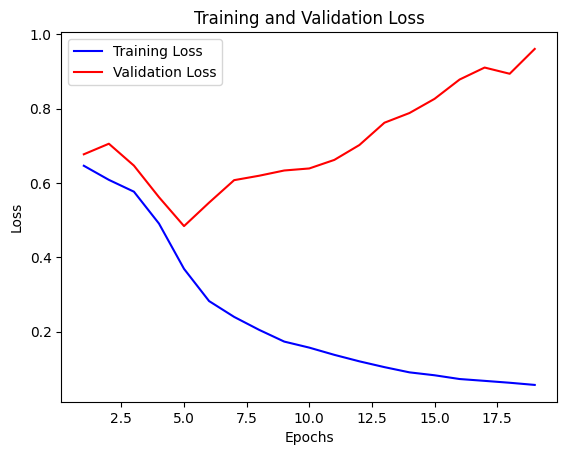

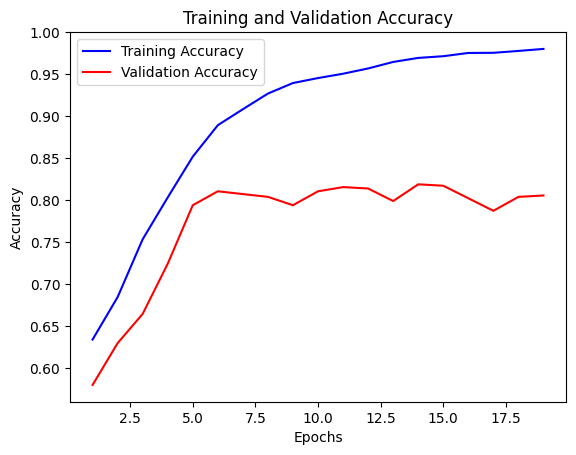

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# 손실값 그래프
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/negative_model')
model.load_weights('/content/drive/MyDrive/negative_model.h5')

In [ ]:
def predict_asdf(text):
  sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', text)
  sentence = okt.morphs(sentence, stem=True) # 토큰화
  sentence = [word for word in sentence if not word in stop_words] # 불용어 제거
  vector  = tokenizer.texts_to_sequences(sentence)
  pad_new = pad_sequences(vector, maxlen = MAX_SEQUENCE_LENGTH) # 패딩
  predictions = model.predict(pad_new)
  predictionsSqueeze = predictions.squeeze()
  predictions = float(predictionsSqueeze.max())
  print(predictionsSqueeze)
  if(predictions < 0.5):
    print("{:.2f}% 확률로 비속어가 섞이지 않은 문장입니다.\n".format((1 - predictions) * 100))
    dir = db.reference('문장/' + str(len(db.reference('문장').get())))
    if((1 - predictions) > 0.7):
      dir.update({'sentence':text, 'negative': 0});
    else:
      dir.update({'sentence':text, 'negative': 1 if(input("비속어인가요? y or n?") == "y") else 0});
  else:
    print("{:.2f}% 확률로 비속어가 섞인 문장입니다.\n".format(predictions * 100))
    dir = db.reference('문장/' + str(len(db.reference('문장').get())))
    if(predictions > 0.7):
      dir.update({'sentence':text, 'negative': 1});
    else:
      dir.update({'sentence':text, 'negative': 1 if(input("비속어인가요? y or n") == "y") else 0})
  if not isinstance(predictionsSqueeze, list):
    predictions = [predictionsSqueeze]
  else:
    predictions = predictionsSqueeze
  result = replaceSentence(predictions[0], text, sentence, 1)
  return result

In [ ]:
# sentenceInput = input('감성분석할 문장을 입력해 주세요.: ')

# print(predict_asdf(sentenceInput))

In [ ]:
def replaceSentence(prediction, sentenceInput, predictionSentence, isFlower):
  result = sentenceInput
  sentenceInput = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\\s ]','', sentenceInput).split()
  for text in sentenceInput:
    preText = text
    text = okt.morphs(text, stem=True) # 토큰화]
    text = [word for word in text if not word in stop_words]
    for word in text:
      if word in predictionSentence:
        if prediction.size != 1:
          index = predictionSentence.index(word)
          pred_value = prediction[index]
        else:
          pred_value = prediction
        if pred_value > 0.5:
          if(word in result):
            if(isFlower):
              result = result.replace(word, makeFlower(word))
            else:
              result = result.replace(word, "\033[31m\033[43m" +word+  "\033[0m")
          else:
            if(isFlower):
              result = result.replace(preText, makeFlower(preText))
            else:
              result = result.replace(preText, "\033[31m\033[43m" +preText+  "\033[0m")
  return result

In [ ]:
def makeFlower(sentence):
  flowers = ["🌸", "🌷", "🌹", "🌺", "🌻", "🌼", "🥀", "🏵", "💐"]
  replaceText = ""
  for _ in sentence:
    replaceText += random.choice(flowers)
  return replaceText

In [ ]:

# print(replaceSentence(predictions[0], sentenceInput, sentence, 0))
# print(replaceSentence(predictions[0], sentenceInput, sentence, 1))

In [ ]:
print(predict_asdf('안녕'))

1/1 [==============================] - 8s 8s/step
0.24115892
75.88% 확률로 비속어가 섞이지 않은 문장입니다.

안녕


# 서버


In [ ]:
!pip install flask-ngrok
!pip install pyngrok==4.1.1
!ngrok authtoken 2SXXq4hvm2nHoG1iRvtIWrrLoRL_DukgtsiQkhYPrRsJJAVh

  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-4.1.1-py3-none-any.whl size=15963 sha256=7c13ed0a922965ea7af4bd835bae5d2d5570533106575b6fee75b6b97d631686
  Stored in directory: /root/.cache/pip/wheels/4c/7c/4c/632fba2ea8e88d8890102eb07bc922e1ca8fa14db5902c91a8
Successfully built pyngrok
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
from flask import Flask, url_for, redirect, render_template, request, jsonify
from flask_ngrok import run_with_ngrok
TEMPLATE_FOLDER = '/content/drive/Shareddrives/수업량유연화 프젝/web/templates'
STATIC_FOLDER = '/content/drive/Shareddrives/수업량유연화 프젝/web/static'
app = Flask(__name__, template_folder=TEMPLATE_FOLDER, static_folder = STATIC_FOLDER)

In [ ]:
@app.route('/', methods=['GET','POST'])
def index():
    if request.method == 'POST':
      value = request.form['id_name']
      value = str(value)
      print(value)
      result = predict_asdf(value)
      print(result)
      return render_template('index.html', text=value, result=result)
    return render_template('index.html')

@app.route('/post', methods=['POST'])
def post():
  value = request.data.decode('utf-8') # 데이터를 불러와 변수 value에 저장
  data = predict_asdf(value)
  return jsonify({"result":data})


In [ ]:
run_with_ngrok(app)
if __name__ == '__main__':
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://b49e-34-90-5-31.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:31:29] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:31:29] "GET /static/js/script.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:31:29] "GET /static/css/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:31:31] "GET /favicon.ico HTTP/1.1" 404 -


1/1 [==============================] - 0s 19ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:32:18] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:33:46] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:42:29] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 131ms/step
[0.18793407 0.90696007 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:44:12] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
[0.18793407 0.90696007 0.94114757]
94.11% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 14:44:32] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 28ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:01:04] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:25:31] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 35ms/step
0.90696
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:28:03] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
[0.18793407 0.22906421]
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:29:48] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:30:54] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 30ms/step
0.90696
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:31:47] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.1879341
81.21% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:37:33] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 30ms/step
[0.22355996 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:39:18] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22342782
77.66% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:41:08] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:43:16] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
[0.18793407 0.22906421]
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:43:28] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
[0.18793407 0.22342782]
77.66% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:44:38] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 28ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:48:51] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 28ms/step
[0.18793407 0.2368461  0.94114757]
94.11% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:49:03] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:49:10] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:54:48] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:57:41] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22906421
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:57:45] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 23ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:57:49] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 15:59:57] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:01:37] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 25ms/step
0.1879341
81.21% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:01:41] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:02:11] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.1879341
81.21% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:02:15] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
0.22906421
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:02:17] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 25ms/step
[0.18793407 0.22906421 0.25194716]
74.81% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:06:51] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:08:13] "POST /post HTTP/1.1" 200 -
ERROR:__main__:Exception on /post [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-39-152ff444d5f8>", line 15, in post
    data = predict_asdf(value)
  File "<ipython-input-6-58e9bc4a6b46>", line 7, in predict_asdf
    predictions = model.predict(pad_new)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py

1/1 [==============================] - 0s 19ms/step
[0.20535888 0.26957354]
73.04% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:08:18] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 20ms/step
[0.26957354 0.22906421]
73.04% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:08:22] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:13:19] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.22906421
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:13:20] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
[0.20535888 0.26957354]
73.04% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:13:28] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:14:58] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.25194716
74.81% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:15:00] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 23ms/step
0.22909136
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:16:28] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 22ms/step
[0.18793407 0.90696007]
90.70% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:16:33] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 18ms/step
[0.23845948 0.23845948]
76.15% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:16:40] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 112ms/step
[0.18793407 0.1796302  0.2258158  0.94114757 0.21612437]
94.11% 확률로 비속어가 섞인 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:16:49] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 19ms/step
0.22087727
77.91% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:16:56] "POST /post HTTP/1.1" 200 -


1/1 [==============================] - 0s 21ms/step
[0.22906421 0.22906421]
77.09% 확률로 비속어가 섞이지 않은 문장입니다.



INFO:werkzeug:127.0.0.1 - - [07/Aug/2023 16:17:06] "POST /post HTTP/1.1" 200 -
